# A TUTORIAL ON VARIANCE-BASED SENSITIVITY ANALYSIS FOR CORRELATED INPUTS

by Sebastian T. Glavind, September, 2020

# Introduction

In this tutorial, we will consider different approaches to perform variance-based sensitivity analysis when the input variables are correlated. First, we will study a regression-based approach introduced by Xu and Gartner (2008); second, we will show how a polynomial chaos expansion (PCE) surrogate can be used for variance decomposition, see e.g. Caniou (2012); and third, we will consider two simulation-based approach introduced in Kucherenko et al.(2012). In this tutorial, we will make use of functionalities from the open source package [`openturns`](http://openturns.org/) for implementing the PCE surrogates.

***
Xu, C., Gertner, G. Z. (2008). Uncertainty and sensitivity analysis for models with correlated parameters. Reliability Engineering \& System Safety, 93 (10), 1563-1573.

Caniou, Y. (2012), Global sensitivity analysis for nested and multiscale modelling. PhD Thesis. Université Blaise Pascal-Clermont-Ferrand II, https://tel.archives-ouvertes.fr/file/index/docid/864175/filename/Caniou-2012CLF22296.pdf

Kucherenko, S., Tarantola, S., & Annoni, P. (2012). Estimation of global sensitivity indices for models with dependent variables. Computer physics communications, 183(4), 937-946.
***

# Prelude

In [1]:
import numpy as np
import sklearn.preprocessing
import scipy.stats as ss
import smt.sampling_methods
import pandas as pd
import openturns as ot
import pickle
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

# Variance decomposition based on regression

In this section, we will implement the regression-based method introduced in Xu and Gertner (2008) and reproduce some of the examples in the paper. The interested reader is referred to the paper for the technical details.

***
Xu, C., Gertner, G. Z. (2008). Uncertainty and sensitivity analysis for models with correlated parameters. Reliability Engineering \& System Safety, 93 (10), 1563-1573.
***

## Implementation of regression-based method

In [2]:
def fit_reg_coef_pseudo_inv(XX, y):
    W = np.linalg.pinv(XX).dot(y)
#     W = (np.linalg.inv(XX.T.dot(XX)).dot(XX.T)).dot(y)
    return(W)

def regression_based_SA(X,y):
    nX, mX = X.shape
    varY = np.var(y)
    meanY = np.mean(y)
    VV = np.zeros([3, mX])
    SS = np.zeros([3, mX])
    for i in range(mX):
        # Total contribution
        xi = X[:,i].reshape(-1,1) 
        XXi = np.concatenate( (np.ones([nX,1]), xi), axis=1)
        theta_i = fit_reg_coef_pseudo_inv(XXi, y)
        yi_est = XXi.dot(theta_i)
        Vi = np.var(yi_est-meanY, axis=0, ddof=1); # print(Vi)
        Si = Vi/varY; # print(Si)
        
        # Uncorrelative contribution
        Xnot_i = X.copy(); 
        Xnot_i = np.delete(Xnot_i, i, axis=1)
        XXnot_i = np.concatenate(( np.ones([nX,1]), Xnot_i ), axis=1)
        eta_i = fit_reg_coef_pseudo_inv(XXnot_i, xi)
        xi_est = XXnot_i.dot(eta_i)

        znot_i = xi - xi_est
        ZZnot_i = np.concatenate(( np.ones([nX,1]), znot_i), axis=1)
        gamma_i = fit_reg_coef_pseudo_inv(ZZnot_i, y)
        ynot_i_est = ZZnot_i.dot(gamma_i)
        Vi_U = np.var(ynot_i_est - meanY, axis=0, ddof=1); # print(Vi_U)
        Si_U = Vi_U/varY; # print(Si_U)
        
        # Correlative contribution
        Vi_C = Vi-Vi_U
        Si_C = Si-Si_U
        
        # book keeping
        VV[:,i] = np.array( [Vi, Vi_U, Vi_C] ).T
        SS[:,i] = np.array( [Si, Si_U, Si_C]).T
    
    return(VV, SS)

## Example from Xu and Gertner (2008), Test case 1

To showcase the approach, we will initially consider the following simple problem: 

$$ y = 2 x_1 + 3 x_2$$

where both $x_i \sim \mathcal{N}(0,1)$ and the Pearson correlation coefficient $\rho = 0.7$. See e.g. Xu and Gertner (2008) for further details.

### Sampling

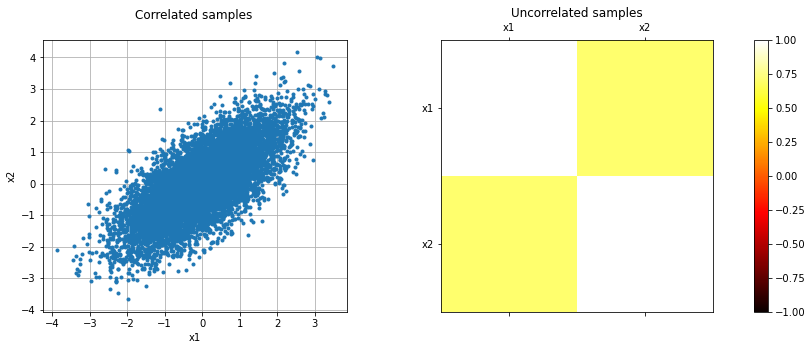

In [3]:
def model_test_case1(N):
    meanX = np.zeros([2])
    covX = np.array([ [1., 0.7], [0.7, 1.] ])
    X = np.random.multivariate_normal(meanX, covX, N)
    y = 2*X[:,0] + 3*X[:,1]
    return(X,y)

# Sampling
np.random.seed(42)
Xc1a, yc1a = model_test_case1(10000)

# Plt samples
varNames = ['x1', 'x2']
y_lab = np.arange(0,2,1);
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

first = ax1.plot(Xc1a[:,0], Xc1a[:,1], '.');
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Correlated samples \n')
ax1.grid()

second = ax2.matshow(np.corrcoef(Xc1a.T), vmin=-1, vmax=1, cmap='hot')
ax2.set_xticks(y_lab)
ax2.set_yticks(y_lab)
ax2.set_xticklabels(varNames);
ax2.set_yticklabels(varNames);
ax2.set_title('Uncorrelated samples')

fig.colorbar(second, ax=[ax1, ax2]);

### Compute regression-based indices

Results: 
 Variances
  [[17.32609661 19.87015799]
 [ 2.01855795  4.56261933]
 [15.30753866 15.30753866]] 
 Sensitivities 
 [[0.79163298 0.90787167]
 [0.09222834 0.20846703]
 [0.69940464 0.69940464]] 



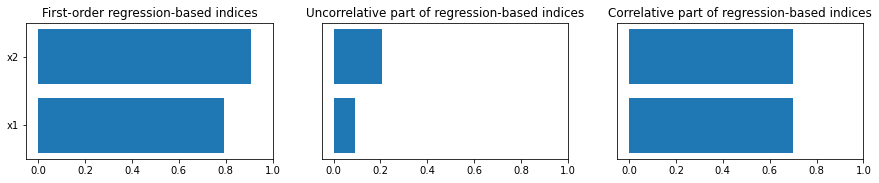

In [4]:
VVc1a, SSc1a = regression_based_SA(Xc1a,yc1a); 
print('Results: \n Variances\n ', VVc1a, '\n Sensitivities \n', SSc1a, '\n')

varNames = ['x1', 'x2']
y_lab = np.arange(0,2,1);
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,2.5))
ax1.barh(y_lab,SSc1a[0,:])
ax1.set_yticks(y_lab)
ax1.set_yticklabels(varNames, fontsize=10);
ax1.set_title('First-order regression-based indices', fontsize=12)
ax1.set_xlim([-0.05, 1]);

ax2.barh(y_lab,SSc1a[1,:])
ax2.get_yaxis().set_visible(False)
# ax2.set_yticks(y_lab)
# ax2.set_yticklabels(varNames[:-1]);
ax2.set_title('Uncorrelative part of regression-based indices', fontsize=12)
ax2.set_xlim([-0.05, 1]);

ax3.barh(y_lab,SSc1a[2,:])
ax3.get_yaxis().set_visible(False)
# ax3.set_yticks(y_lab)
# ax3.set_yticklabels(varNames[:-1]);
ax3.set_title('Correlative part of regression-based indices',fontsize=12);
ax3.set_xlim([-0.05, 1]);

## Example from Xu and Gertner (2008), Test case 2

To showcase the approach, we will initially consider the following simple problem: 

$$ y = \frac{x_1 x_2}{x_3}$$

where all $x_i \sim \mathcal{U}(1,10)$ and the Spearman's rank correlation matrix for the domain variables is;

$$ 
\text{corr}(\mathbf{X}) =
\begin{bmatrix}
1 & 0.4 & 0.2 \\
0.4 & 1 & 0.4 \\
0.2 & 0.4 & 1 \\
\end{bmatrix}. $$

See e.g. Xu and Gertner (2008) for further details.

### Copula implementations

In [5]:
# This implementation corresponds to a standard Gaussian copula, see e.g.
# https://se.mathworks.com/help/stats/copulas-generate-correlated-samples.html
# https://www.sciencedirect.com/science/article/abs/pii/0266892086900330?via%3Dihub
def gaussian_copula_c1b(SpearmansRankCorr, lower, upper, Nsamp):
    m = SpearmansRankCorr.shape[1]
    PearsonsCorr = 2 * np.sin( SpearmansRankCorr * (np.pi/6) )
    MVN = ss.multivariate_normal( mean = np.zeros(m), cov = PearsonsCorr )
    Z = MVN.rvs(size=Nsamp) 
    U = ss.norm.cdf(Z)
    X = np.zeros(U.shape)
    for i in range(m):
        X[:,i] = ss.uniform(loc=lower, scale=upper-lower).ppf(U[:,i]) # define transformation
    y = (X[:,0] * X[:,1]) / X[:,2]
    return(X,y)

# This implementation corresponds to a Gaussian copula with a latin hypercube design
def gaussian_copula_c1b_lhs(SpearmansRankCorr, lower, upper, Nsamp):
    m = SpearmansRankCorr.shape[1] # no. of variables
    PearsonsCorr = 2 * np.sin( SpearmansRankCorr * (np.pi/6) ) # convert spearman's correlations to Pearson's (linear) correlations
    L = np.linalg.cholesky(PearsonsCorr) # cholesky decomposition of covariance (correlation) matrix
    lhs_sampler = smt.sampling_methods.LHS(xlimits=np.tile(np.array([0,1]), (m, 1))) # latin hypercube sampling
    Ulhs = lhs_sampler(Nsamp) # do.
    Zuncor = ss.norm.ppf(Ulhs) # uncorrelated standard normal samples
    Zcor = np.dot(L, Zuncor.T).T # correlated standard normal samples
    U = ss.norm.cdf(Zcor) # correlated uniformly distributed samples
    X = np.zeros(U.shape) 
    for i in range(m):
        X[:,i] = ss.uniform(loc=lower, scale=upper-lower).ppf(U[:,i]) # define transformation
    y = (X[:,0] * X[:,1]) / X[:,2]
    return(X,y)

### Sampling

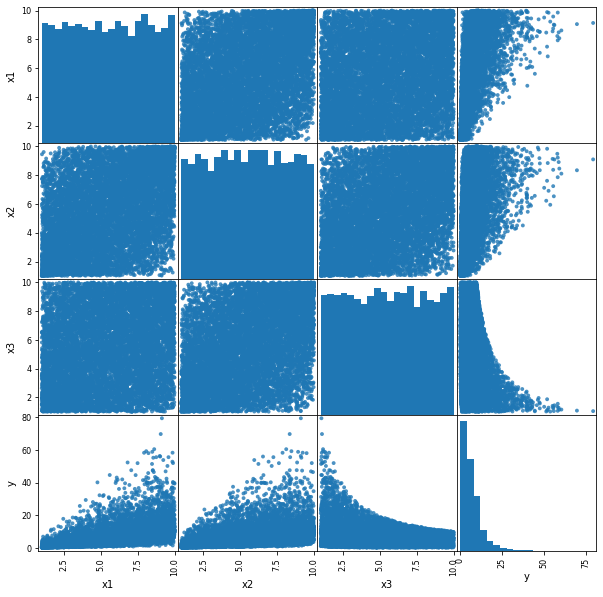

In [6]:
# Standard Gaussian copula
SpearmansRankCorr = np.array([ [1., 0.4, 0.2], [0.4, 1., 0.4], [0.2, 0.4, 1.] ])
np.random.seed(42)
Xc1b, yc1b = gaussian_copula_c1b(SpearmansRankCorr, 1, 10, 10000) # regular sampling
# plotting
dfXyc1b = pd.DataFrame(np.hstack((Xc1b, yc1b.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc1b, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

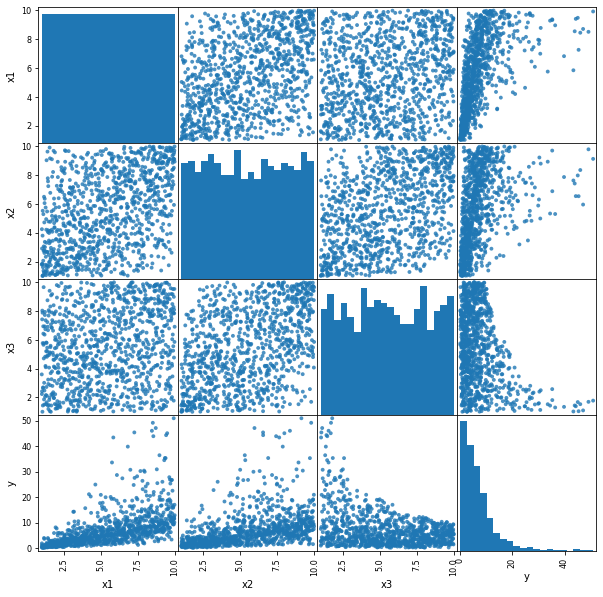

In [7]:
# Gaussian copula with a lhs design
np.random.seed(42)
Xc1b_lhs, yc1b_lhs = gaussian_copula_c1b_lhs(SpearmansRankCorr, 1, 10, 1000)
dfXyc1b_lhs = pd.DataFrame(np.hstack((Xc1b_lhs, yc1b_lhs.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc1b_lhs, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

### Compute regression-based indices

Results using standard sampling (blue in figure): 
 Variances
  [[ 13.88049579   8.67158884   4.95011882]
 [  8.84300111   8.35190079  15.28616839]
 [  5.03749469   0.31968805 -10.33604957]] 
 Sensitivities 
 [[ 0.31127453  0.19446313  0.11100799]
 [ 0.19830711  0.18729403  0.34279718]
 [ 0.11296742  0.00716911 -0.2317892 ]] 

Results using lhs sampling (red transparent, overlay in figure): 
 Variances
  [[ 15.87349264   8.71519555   5.83001356]
 [  9.76054245   8.5555967   17.15964635]
 [  6.11295019   0.15959885 -11.32963279]] 
 Sensitivities 
 [[ 0.31897979  0.17513293  0.11715484]
 [ 0.1961393   0.17192577  0.3448252 ]
 [ 0.12284049  0.00320716 -0.22767036]] 



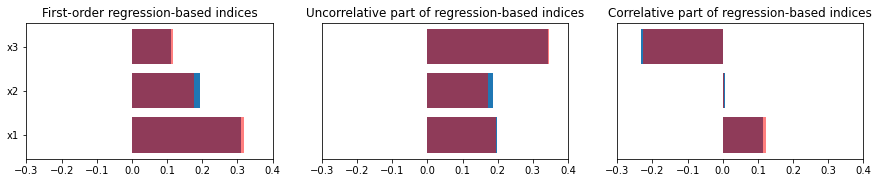

In [8]:
VVc1b, SSc1b = regression_based_SA(Xc1b,yc1b); 
print('Results using standard sampling (blue in figure): \n Variances\n ', VVc1b, '\n Sensitivities \n', SSc1b, '\n')

VVc1b_lhs, SSc1b_lhs = regression_based_SA(Xc1b_lhs,yc1b_lhs); 
print('Results using lhs sampling (red transparent, overlay in figure): \n Variances\n ', VVc1b_lhs, '\n Sensitivities \n', SSc1b_lhs, '\n')

varNames = ['x1', 'x2', 'x3']
y_lab = np.arange(0,3,1);
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,2.5))
ax1.barh(y_lab,SSc1b[0,:])
ax1.barh(y_lab,SSc1b_lhs[0,:], alpha = 0.5, color= 'r')
ax1.set_yticks(y_lab)
ax1.set_yticklabels(varNames, fontsize=10);
ax1.set_title('First-order regression-based indices', fontsize=12)
ax1.set_xlim([-0.3, 0.4]);

ax2.barh(y_lab,SSc1b[1,:])
ax2.barh(y_lab,SSc1b_lhs[1,:], alpha = 0.5, color= 'r')
ax2.get_yaxis().set_visible(False)
ax2.set_title('Uncorrelative part of regression-based indices', fontsize=12)
ax2.set_xlim([-0.3, 0.4]);

ax3.barh(y_lab,SSc1b[2,:])
ax3.barh(y_lab,SSc1b_lhs[2,:], alpha = 0.5, color= 'r')
ax3.get_yaxis().set_visible(False)
ax3.set_title('Correlative part of regression-based indices',fontsize=12);
ax3.set_xlim([-0.3, 0.4]);

# Variance decomposition based on polynomial chaos expansions

In this section, we will make use of polynomial chaos expansions to compute the components of a functional ANCOVA decomposition in order to approximate the ANCOVA indices. The interested reader is referred to e.g. Caniou (2012) for the technical details, as well as a description of the examples considered in this section. At the end of the section, we extend the last example by considering how we can estimate the sampling variability of the ANCOVA indices by use of a parametric bootstrap procedure. Note that we will make use of functionalities from the open source package [`openturns`](http://openturns.org/) for implementing the PCE surrogates in this section.

***
Caniou, Y. (2012), Global sensitivity analysis for nested and multiscale modelling. PhD Thesis. Université Blaise Pascal-Clermont-Ferrand II, https://tel.archives-ouvertes.fr/file/index/docid/864175/filename/Caniou-2012CLF22296.pdf
***

## Example from Caniou (2012), sec. 4.5.2.1-2

To showcase the approach, we will initially consider the following simple problem: 

$$ y = \sum_{i=1}^5 x_i$$

where all $x_i \sim \mathcal{N}(0.5,1)$. First, we consider the case of no correlation, and second, we consider a correlation between the domain variables defined by a Gaussian copula with linear correlation matrix;

$$ 
\text{corr}(\mathbf{X}) =
\begin{bmatrix}
1 & 0.6 & 0.2 & 0 & 0 \\
0.6 & 1 & 0 & 0 & 0 \\
0.2 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0.2 \\
0 & 0 & 0 & 0.2 & 1 \\
\end{bmatrix}. $$

See e.g. Caniou, Y. (2012) for further details.

### Implement sample generator for dependent and independent sampling of covariates

In [9]:
def genDependentsamples_c2(meanX, covX, N, weights):
    X = np.random.multivariate_normal(meanX, covX, N)
    y = X.dot(weights)
    return(X,y)

def genIndependentsamples_c2(meanX, covX, N, weights):
    indices_diagonal = np.diag_indices_from(covX)
    covXI = np.zeros(covX.shape); covXI[indices_diagonal] = covX[indices_diagonal]
    XI = np.random.multivariate_normal(meanX, covXI, N)
    yI = XI.dot(weights)
    return(XI,yI)

### Sampling

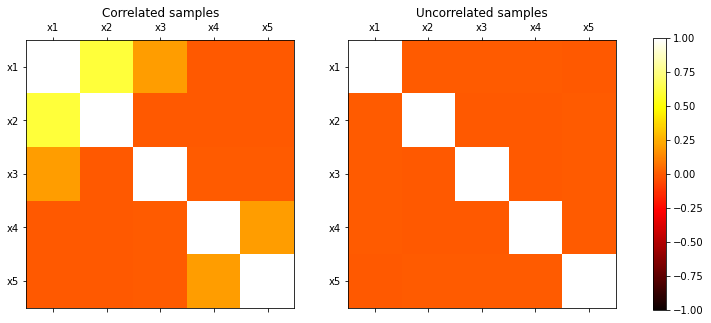

In [10]:
Nc2a = 100000
meanXc2a = np.ones([5])*0.5
covXc2a = np.array([[1., 0.6, 0.2, 0, 0], 
                    [0.6, 1., 0, 0, 0],
                    [0.2, 0, 1., 0, 0],
                    [0, 0, 0, 1., 0.2],
                    [0, 0, 0, 0.2, 1.]])
weights_c2a = np.ones([5])

# Sample correlated and uncorrelated samples
np.random.seed(42)
XDc2a, yDc2a = genDependentsamples_c2(meanXc2a, covXc2a, Nc2a, weights_c2a)
XIc2a, yIc2a = genIndependentsamples_c2(meanXc2a, covXc2a, Nc2a, weights_c2a)

# Plt samples
varNames = ['x1', 'x2', 'x3', 'x4', 'x5']
y_lab = np.arange(0,5,1);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.2,5))

first = ax1.matshow(np.corrcoef(XDc2a.T), vmin=-1, vmax=1, cmap='hot')
ax1.set_xticks(y_lab)
ax1.set_yticks(y_lab)
ax1.set_xticklabels(varNames);
ax1.set_yticklabels(varNames);
ax1.set_title('Correlated samples')

ax2.matshow(np.corrcoef(XIc2a.T), vmin=-1, vmax=1, cmap='hot')
ax2.set_xticks(y_lab)
ax2.set_yticks(y_lab)
ax2.set_xticklabels(varNames);
ax2.set_yticklabels(varNames);
ax2.set_title('Uncorrelated samples')

fig.colorbar(first, ax=[ax1, ax2]);

### Standardize variables

In [11]:
# Standardize features
scaler_c2a = sklearn.preprocessing.StandardScaler()
# scaler = sklearn.preprocessing.MinMaxScaler()
scaler_c2a.fit(XIc2a)
sXIc2a = scaler_c2a.transform(XIc2a)
sXDc2a = scaler_c2a.transform(XDc2a)

# Standardize outputs - no needed for single-outputs
scaler_y_c2a = sklearn.preprocessing.StandardScaler()
# scaler_y = sklearn.preprocessing.MinMaxScaler()
scaler_y_c2a.fit(yIc2a.reshape(-1,1) )
syIc2a = scaler_y_c2a.transform(yIc2a.reshape(-1,1))
syDc2a = scaler_y_c2a.transform(yDc2a.reshape(-1,1))

### Implementation and fitting of polynomial chaos expansion using openturns

In [12]:
def buildAndFit_pce_model_c2(XI_ot, yI_ot):
    # Build and fit PCE
    PCEinputDimension = XI_ot.getDimension();
    PCEdistribution = ot.ComposedDistribution([ot.Normal()] * PCEinputDimension) # Gaussian marginals
    PCEpolyColl = ot.PolynomialFamilyCollection(PCEinputDimension)
    for i in range(XI_ot.getDimension()):
        marginal = PCEdistribution.getMarginal(i)
        PCEpolyColl[i] = ot.StandardDistributionPolynomialFactory(marginal) # equivalent to ot.HermiteFactory()
    PCEenumerateFunction = ot.LinearEnumerateFunction(PCEinputDimension)
    PCEmultivariateBasis = ot.OrthogonalProductPolynomialFactory(PCEpolyColl, PCEenumerateFunction) # Create the multivariate orthonormal basis
    # PCEadaptiveStrategy = ot.FixedStrategy(PCEmultivariateBasis,  PCEenumerateFunction.getStrataCumulatedCardinal(1)) # degree 1 approx
    PCEadaptiveStrategy = ot.SequentialStrategy(PCEmultivariateBasis, 20)
    PCEselectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    PCEprojectionStrategy = ot.LeastSquaresStrategy(XI_ot, yI_ot, PCEselectionAlgorithm)
    # PCEprojectionStrategy = ot.LeastSquaresStrategy(sXtrain_ot, sytrain_ot, PCEselectionAlgorithm)
    PCEmodel = ot.FunctionalChaosAlgorithm(XI_ot, yI_ot, PCEdistribution, PCEadaptiveStrategy, 
                                           PCEprojectionStrategy)
    PCEmodel.run()
    PCEmodel_res = ot.FunctionalChaosResult(PCEmodel.getResult())
    PCEmodel_res_metamodel = PCEmodel_res.getMetaModel()
    return(PCEmodel, PCEmodel_res, PCEmodel_res_metamodel)

    # PCEmodel = ot.FunctionalChaosAlgorithm(XI_ot, yI_ot)
    # PCEmodel.run()
    # PCEmodel_res = ot.FunctionalChaosResult(PCEmodel.getResult())
    # PCEmodel_res_metamodel = PCEmodel_res.getMetaModel()


# openturns format
sXIc2a_ot = ot.Sample(sXIc2a)
sXDc2a_ot = ot.Sample(sXDc2a)
syIc2a_ot = ot.Sample(syIc2a)
syDc2a_ot = ot.Sample(syDc2a)

# Define and fit model
PCEmodel_c2a, PCEmodel_res_c2a, PCEmodel_res_metamodel_c2a = buildAndFit_pce_model_c2(sXIc2a_ot, syIc2a_ot)

### ANOVA indices

In [13]:
def get_anova_indices_c2(PCEmodel_res, dimension):
    SAsobol = ot.FunctionalChaosSobolIndices(PCEmodel_res)
    Sobol_first_order = [SAsobol.getSobolIndex(i) for i in range(dimension)]; 
    Sobol_total_order = [SAsobol.getSobolTotalIndex(i) for i in range(dimension)]; 
    return(Sobol_first_order, Sobol_total_order)
    
Sobol_first_order_c2a, Sobol_total_order_c2a = get_anova_indices_c2(PCEmodel_res_c2a, sXIc2a.shape[1])    
print('ANOVA first order index: \n', np.round(Sobol_first_order_c2a, 2), ', Sum: ', sum(Sobol_first_order_c2a))  
print('ANOVA total order index: \n', np.round(Sobol_total_order_c2a, 2), ', Sum: ', sum(Sobol_total_order_c2a))

ANOVA first order index: 
 [0.2 0.2 0.2 0.2 0.2] , Sum:  1.0
ANOVA total order index: 
 [0.2 0.2 0.2 0.2 0.2] , Sum:  1.0


### ANCOVA for the independent case

In [14]:
def get_ancova_indices_c2(PCEmodel_res, X_ot):
    # Perform the decomposition
    ancova = ot.ANCOVA(PCEmodel_res, X_ot)
    # Compute the ANCOVA indices (first order and uncorrelated indices are computed together)
    indices = ancova.getIndices();
    # Retrieve uncorrelated indices
    uncorrelatedIndices = ancova.getUncorrelatedIndices();
    # Retrieve correlated indices:
    correlatedIndices = indices - uncorrelatedIndices
    return(indices, uncorrelatedIndices, correlatedIndices)

indicesI_c2a, uncorrelatedIndicesI_c2a, correlatedIndicesI_c2a = get_ancova_indices_c2(PCEmodel_res_c2a, sXIc2a_ot)
# print('ANCOVA from sampled data set \n')
print("ANCOVA indices: \n", np.round(indicesI_c2a, 2), ', Sum: ', round(sum(indicesI_c2a),2) )
print("ANCOVA uncorrelated indices: \n", np.round(uncorrelatedIndicesI_c2a, 2), ', Sum: ', round(sum(uncorrelatedIndicesI_c2a),2) )
print("ANCOVA correlated indices: \n", np.round(correlatedIndicesI_c2a, 2), ', Sum: ', round(sum(correlatedIndicesI_c2a),2))

ANCOVA indices: 
 [0.2 0.2 0.2 0.2 0.2] , Sum:  1.0
ANCOVA uncorrelated indices: 
 [0.2 0.2 0.2 0.2 0.2] , Sum:  0.99
ANCOVA correlated indices: 
 [ 0.  0. -0.  0.  0.] , Sum:  0.01


### ANCOVA for the dependent case

In [15]:
indicesD_c2a, uncorrelatedIndicesD_c2a, correlatedIndicesD_c2a = get_ancova_indices_c2(PCEmodel_res_c2a, sXDc2a_ot)
# print('ANCOVA from sampled data set \n')
print("ANCOVA indices: \n", np.round(indicesD_c2a, 2), ', Sum: ', round(sum(indicesD_c2a),2) )
print("ANCOVA uncorrelated indices: \n", np.round(uncorrelatedIndicesD_c2a, 2), ', Sum: ', round(sum(uncorrelatedIndicesD_c2a),2) )
print("ANCOVA correlated indices: \n", np.round(correlatedIndicesD_c2a, 2), ', Sum: ', round(sum(correlatedIndicesD_c2a),2))

ANCOVA indices: 
 [0.26 0.23 0.17 0.17 0.17] , Sum:  1.0
ANCOVA uncorrelated indices: 
 [0.14 0.14 0.14 0.14 0.14] , Sum:  0.72
ANCOVA correlated indices: 
 [0.11 0.08 0.03 0.03 0.03] , Sum:  0.28


## Example from Caniou (2012), sec. 4.5.2.3

In this section, we consider a model that is slightly altered compared to the example in the previous section, thus including distinct structural contributions, i.e. 

$$ y = 5 x_1 + 4 x_2 + 3 x_3 + 2 x_4 + x_5 $$

where again all $x_i \sim \mathcal{N}(0.5,1)$ and the correlation between the domain variables is defined by a Gaussian copula with linear correlation matrix;

$$ 
\text{corr}(\mathbf{X}) =
\begin{bmatrix}
1 & 0.6 & 0.2 & 0 & 0 \\
0.6 & 1 & 0 & 0 & 0 \\
0.2 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0.2 \\
0 & 0 & 0 & 0.2 & 1 \\
\end{bmatrix}. $$

See e.g. Caniou, Y. (2012) for further details.

### Sampling

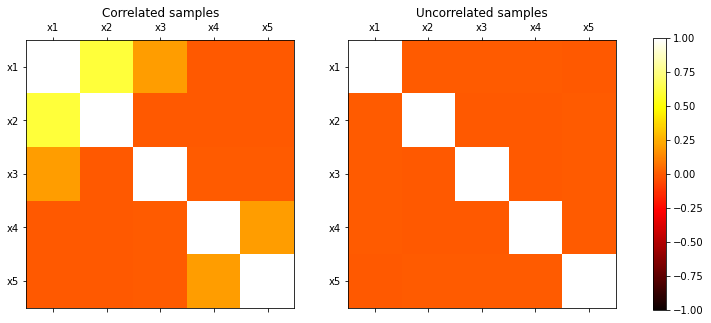

In [16]:
Nc2b = 100000
meanXc2b = meanXc2a
covXc2b = covXc2a
weights_c2b = np.array([5,4,3,2,1])

# Sample correlated and uncorrelated samples
np.random.seed(42)
XDc2b, yDc2b = genDependentsamples_c2(meanXc2b, covXc2b, Nc2b, weights_c2b)
XIc2b, yIc2b = genIndependentsamples_c2(meanXc2b, covXc2b, Nc2b, weights_c2b)

# Plt samples
varNames = ['x1', 'x2', 'x3', 'x4', 'x5']
y_lab = np.arange(0,5,1);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.2,5))

first = ax1.matshow(np.corrcoef(XDc2b.T), vmin=-1, vmax=1, cmap='hot')
ax1.set_xticks(y_lab)
ax1.set_yticks(y_lab)
ax1.set_xticklabels(varNames);
ax1.set_yticklabels(varNames);
ax1.set_title('Correlated samples')

ax2.matshow(np.corrcoef(XIc2b.T), vmin=-1, vmax=1, cmap='hot')
ax2.set_xticks(y_lab)
ax2.set_yticks(y_lab)
ax2.set_xticklabels(varNames);
ax2.set_yticklabels(varNames);
ax2.set_title('Uncorrelated samples')

fig.colorbar(first, ax=[ax1, ax2]);

### Standardize variables

In [17]:
# Standardize features
scaler_c2b = sklearn.preprocessing.StandardScaler()
# scaler = sklearn.preprocessing.MinMaxScaler()
scaler_c2b.fit(XIc2b)
sXIc2b = scaler_c2b.transform(XIc2b)
sXDc2b = scaler_c2b.transform(XDc2b)

# Standardize outputs - no needed for single-outputs
scaler_y_c2b = sklearn.preprocessing.StandardScaler()
# scaler_y = sklearn.preprocessing.MinMaxScaler()
scaler_y_c2b.fit(yIc2b.reshape(-1,1) )
syIc2b = scaler_y_c2b.transform(yIc2b.reshape(-1,1))
syDc2b = scaler_y_c2b.transform(yDc2b.reshape(-1,1))

### Implementation and fitting of polynomial chaos expansion using openturns

In [18]:
# openturns format
sXIc2b_ot = ot.Sample(sXIc2b)
sXDc2b_ot = ot.Sample(sXDc2b)
syIc2b_ot = ot.Sample(syIc2b)
syDc2b_ot = ot.Sample(syDc2b)

# Define and fit model
PCEmodel_c2b, PCEmodel_res_c2b, PCEmodel_res_metamodel_c2b = buildAndFit_pce_model_c2(sXIc2b_ot, syIc2b_ot)

### ANOVA indices

In [19]:
Sobol_first_order_c2b, Sobol_total_order_c2b = get_anova_indices_c2(PCEmodel_res_c2b, sXIc2b.shape[1])    
print('ANOVA first order index: \n', np.round(Sobol_first_order_c2b, 3), ', Sum: ', round(sum(Sobol_first_order_c2b),3) )  
print('ANOVA total order index: \n', np.round(Sobol_total_order_c2b, 3), ', Sum: ', round(sum(Sobol_total_order_c2b),3) )

ANOVA first order index: 
 [0.454 0.292 0.163 0.073 0.018] , Sum:  1.0
ANOVA total order index: 
 [0.454 0.292 0.163 0.073 0.018] , Sum:  1.0


### ANCOVA indices

In [20]:
indicesD_c2b, uncorrelatedIndicesD_c2b, correlatedIndicesD_c2b = get_ancova_indices_c2(PCEmodel_res_c2b, sXDc2b_ot)
# print('ANCOVA from sampled data set \n')
print("ANCOVA indices: \n", np.round(indicesD_c2b, 2), ', Sum: ', round(sum(indicesD_c2b),3) )
print("ANCOVA uncorrelated indices: \n", np.round(uncorrelatedIndicesD_c2b, 2), ', Sum: ', round(sum(uncorrelatedIndicesD_c2b),3) )
print("ANCOVA correlated indices: \n", np.round(correlatedIndicesD_c2b, 2), ', Sum: ', round(sum(correlatedIndicesD_c2b),3))

ANCOVA indices: 
 [0.47 0.33 0.14 0.05 0.02] , Sum:  1.0
ANCOVA uncorrelated indices: 
 [0.29 0.19 0.1  0.05 0.01] , Sum:  0.642
ANCOVA correlated indices: 
 [0.18 0.14 0.03 0.   0.  ] , Sum:  0.358


### Quantifying the uncertainty in the ANCOVA indices using parametric bootstrapping

In [21]:
# Tc2b_ = 1000
# Nc2b_ = 10000
# SSc2b_T_ = np.zeros([Tc2b_, len(meanXc2b)])
# SSc2b_U_ = np.zeros([Tc2b_, len(meanXc2b)])
# SSc2b_C_ = np.zeros([Tc2b_, len(meanXc2b)])
# for t in range(Tc2b_):
#     XDc2b_, yDc2b_ = genDependentsamples_c2(meanXc2b, covXc2b, Nc2b_, weights_c2b)
#     XIc2b_, yIc2b_ = genIndependentsamples_c2(meanXc2b, covXc2b, Nc2b_, weights_c2b)
#     # Standardize features
#     scaler_c2b_ = sklearn.preprocessing.StandardScaler()
#     scaler_c2b_.fit(XIc2b_)
#     sXIc2b_ = scaler_c2b_.transform(XIc2b_)
#     sXDc2b_ = scaler_c2b_.transform(XDc2b_)
#     # Standardize outputs - not needed for single-outputs
#     scaler_y_c2b_ = sklearn.preprocessing.StandardScaler()
#     scaler_y_c2b_.fit(yIc2b_.reshape(-1,1) )
#     syIc2b_ = scaler_y_c2b_.transform(yIc2b_.reshape(-1,1))
#     syDc2b_ = scaler_y_c2b_.transform(yDc2b_.reshape(-1,1))
#     # openturns format
#     sXIc2b_ot_ = ot.Sample(sXIc2b_)
#     sXDc2b_ot_ = ot.Sample(sXDc2b_)
#     syIc2b_ot_ = ot.Sample(syIc2b_)
#     syDc2b_ot_ = ot.Sample(syDc2b_)
#     # Define and fit model
#     PCEmodel_c2b_, PCEmodel_res_c2b_, PCEmodel_res_metamodel_c2b_ = buildAndFit_pce_model_c2(sXIc2b_ot_, syIc2b_ot_)
#     # ANCOVA indices
#     indicesD_c2b_, uncorrelatedIndicesD_c2b_, correlatedIndicesD_c2b_ = get_ancova_indices_c2(PCEmodel_res_c2b_, sXDc2b_ot_)
#     SSc2b_T_[t,:] = indicesD_c2b_
#     SSc2b_U_[t,:] = uncorrelatedIndicesD_c2b_
#     SSc2b_C_[t,:] = correlatedIndicesD_c2b_

# # save results
# with open('SA_varianceBased_correlatedInputs_boot_c2b.pkl', 'wb') as f:
#     pickle.dump((SSc2b_T_, SSc2b_U_, SSc2b_C_), f)

# load results
SSc2b_T_, SSc2b_U_, SSc2b_C_ = pickle.load(open('SA_varianceBased_correlatedInputs_boot_c2b.pkl', 'rb'))

ANCOVA indices: 
 [0.47 0.33 0.14 0.05 0.02] , Sum:  1.0


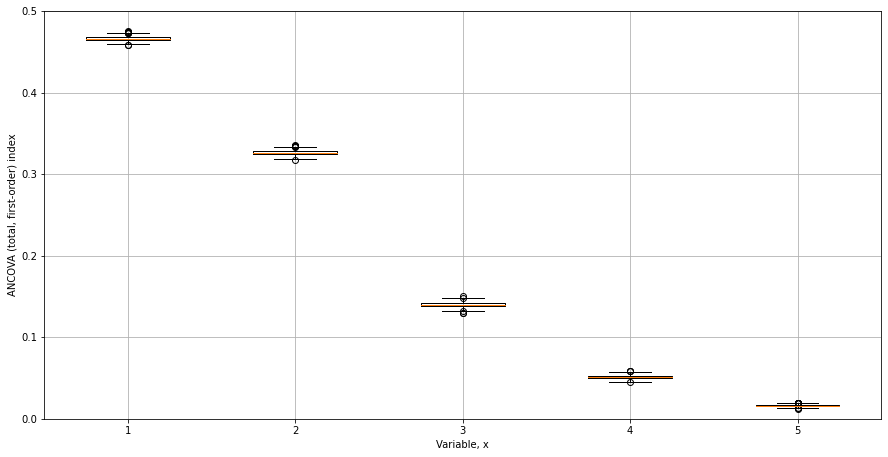

In [22]:
print("ANCOVA indices: \n", np.round(indicesD_c2b, 2), ', Sum: ', round(sum(indicesD_c2b),3) )

plt.figure(figsize=(15,7.5))
plt.boxplot(SSc2b_T_);
plt.xlabel('Variable, x')
plt.ylabel('ANCOVA (total, first-order) index')
plt.ylim([0,0.5])
plt.grid()

ANCOVA uncorrelated indices: 
 [0.29 0.19 0.1  0.05 0.01] , Sum:  0.642


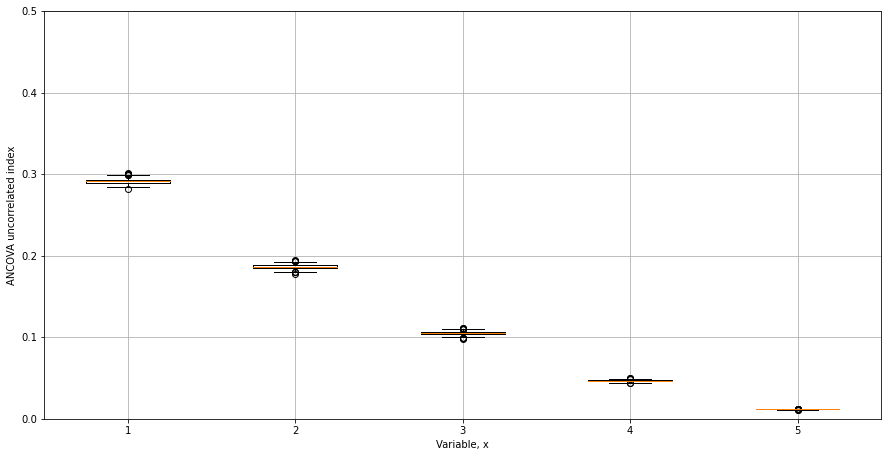

In [23]:
print("ANCOVA uncorrelated indices: \n", np.round(uncorrelatedIndicesD_c2b, 2), ', Sum: ', round(sum(uncorrelatedIndicesD_c2b),3) )

plt.figure(figsize=(15,7.5))
plt.boxplot(SSc2b_U_);
plt.xlabel('Variable, x')
plt.ylabel('ANCOVA uncorrelated index')
plt.ylim([0,0.5])
plt.grid()

ANCOVA correlated indices: 
 [0.18 0.14 0.03 0.   0.  ] , Sum:  0.358


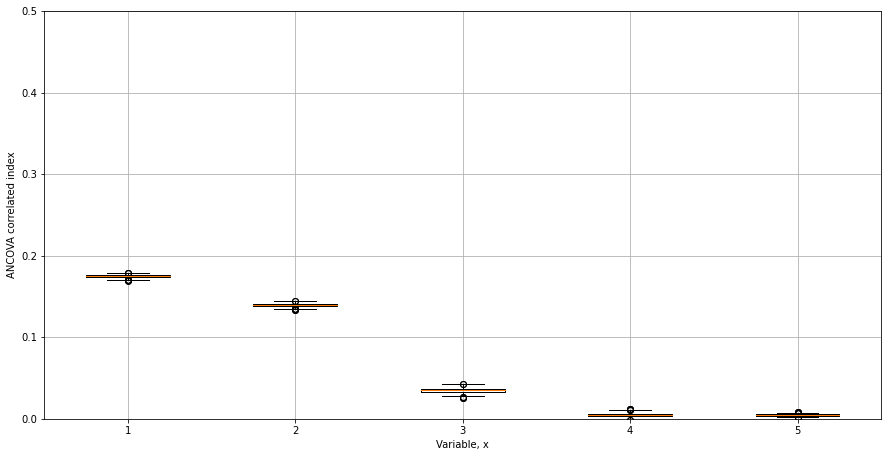

In [24]:
print("ANCOVA correlated indices: \n", np.round(correlatedIndicesD_c2b, 2), ', Sum: ', round(sum(correlatedIndicesD_c2b),3))

plt.figure(figsize=(15,7.5))
plt.boxplot(SSc2b_C_);
plt.xlabel('Variable, x')
plt.ylabel('ANCOVA correlated index')
plt.ylim([0,0.5])
plt.grid()

# Random sampling with binning

In this section, we consider a simple divide and conquer scheme, where the conditional variances are calculated as

$$ \mathbb{V}_i = \frac{1}{B} \sum_{b=1}^B \left( \frac{1}{N_b} \sum_{n_b=1}^{N_b} f(\mathbf{x}[n_b]|x_i \in b) \right)^2 - f_0^2, $$

where $B$ is the number of bins, and $N_b$ is the number of observations of $X_i$ that fall in bin $b \in \{1,2,...,B\}$. See e.g. Kucherenko et al.(2012) for further details.

***
Kucherenko, S., Tarantola, S., & Annoni, P. (2012). Estimation of global sensitivity indices for models with dependent variables. Computer physics communications, 183(4), 937-946.
***

## Example from Kucherenko et al.(2012), Sec. 3.3 and test case 1 (linear, two variable case)

To showcase the approach, we will initially consider the following simple problem: 

$$ y = x_1 + x_2$$

where $x_1 \sim \mathcal{N}(0,1)$ and $x_2 \sim \mathcal{N}(0,2)$. For this simple problem, we can also easily derive the analytical solution:

$$ \mathbb{V}_y = \text{var}(x_1 + x_2) = \sigma_{x_1}^2 + \sigma_{x_2}^2 + 2 \rho \sigma_{x_1} \sigma_{x_2}$$

$$ \mathbb{V}_1 = (x_1 + \rho x_2)^2 = \sigma_{x_1}^2 + \rho^2 \sigma_{x_2}^2 + 2 \rho \sigma_{x_1} \sigma_{x_2}; \quad S_1 = \frac{\mathbb{V}_1}{\mathbb{V}_y} \ \text{and} \ S_1^T = 1 - S_2 $$

$$ \mathbb{V}_2 = (\rho x_1 + x_2)^2 = \rho^2 \sigma_{x_1}^2 + \sigma_{x_2}^2 + 2 \rho \sigma_{x_1} \sigma_{x_2};  \quad S_2 = \frac{\mathbb{V}_2}{\mathbb{V}_y} \ \text{and} \ S_2^T = 1 - S_1. $$

See e.g. Kucherenko et al.(2012) for further details.

In [25]:
def lhs_Zuncor_sampler_c3a(mX, Nsamp):
    lhs_sampler = smt.sampling_methods.LHS(xlimits=np.tile(np.array([0,1]), (mX, 1))) # latin hypercube sampling
    Ulhs = lhs_sampler(Nsamp) # do.
    Zuncor = ss.norm.ppf(Ulhs) # uncorrelated standard normal samples
    return(Zuncor)

def genCorrelatedSamples_3a(Zuncor, PearsonsCorr, meanX, stdX):
    L = np.linalg.cholesky(PearsonsCorr) # cholesky decomposition of covariance (correlation) matrix
    Zcor = np.dot(L, Zuncor.T).T # correlated standard normal samples
    Xcor = Zcor * stdX + meanX
    ycor = Xcor[:,0] + Xcor[:,1];
    return(Xcor, ycor)

def randomSamplingWithBinning_c3a(meanX, stdX, rho, Nsamp, Nbins):
    # initialization
    mX = len(meanX)
    nRho = len(rho)
    subset = Nsamp / Nbins; 
    # allocate objects
    varY = np.zeros([nRho])
    varY_true = np.zeros([nRho])
    VV = np.zeros([nRho, mX])
    SS = np.zeros([nRho, mX])
    VV_true = np.zeros([nRho, mX])
    SS_true = np.zeros([nRho, mX])
    # Sample independent realizations in Z space
    Zuncor = lhs_Zuncor_sampler_c3a(mX, Nsamp)
    # loop over rho vector
    for j in range(nRho):
        PearsonsCorr = np.ones([2,2]); PearsonsCorr[0,1] = PearsonsCorr[1,0] = rho[j] # define linear correlation matrix
        X, y = genCorrelatedSamples_3a(Zuncor, PearsonsCorr, meanX, stdX) # transform samples to dependent samples in X space
        # model output variance; experical and analytical solution
        varY[j] = np.var(y)   
        varY_true[j] = stdX.dot(stdX) + 2*rho[j]*np.prod(stdX)
        f0Y = np.mean(y) 
        # loop over variables
        for i in range(mX):
            # sort arrays according to Xi
            ix = np.argsort(X[:,i])
            yi = y[ix]; # Xi = X[ix,i];
            # allocate object for mean output in bin k of Xi
            meanYik = np.zeros([Nbins])
            # loop over bins
            for k in range(Nbins):
                kind = np.arange(k*subset, (k+1)*subset, 1).astype(int);
                yik = yi[kind]; # Xik = Xi[kind]; 
                meanYik[k] = np.mean(yik);

#             VV[j,i] = np.var(meanYik)
            VV[j,i] = np.mean(meanYik**2) - f0Y**2
            SS[j,i] = VV[j,i] / varY[j]

            if i==0:
                VV_true[j,i] = stdX[0]**2 + rho[j]**2*stdX[1]**2 + 2*rho[j]*np.prod(stdX)
            else:
                VV_true[j,i] = stdX[1]**2 + rho[j]**2*stdX[0]**2 + 2*rho[j]*np.prod(stdX)
            SS_true[j,i] = VV_true[j,i] / varY_true[j]
            
    return(varY, varY_true, VV, SS, VV_true, SS_true)

In [26]:
mXc3a = 2
meanXc3a = np.zeros([mXc3a])
stdXc3a = np.array([1,2])
rho_c3a = np.arange(-0.95, 1, 0.05); nRho_c3a = len(rho_c3a)
Nsamp_c3a = 5000 # number of samples (should be devidable by Nbins)
Nbins_c3a = 50; # define number of slices

np.random.seed(42)
varYc3a, varYc3a_true, VVc3a, SSc3a, VVc3a_true, SSc3a_true = randomSamplingWithBinning_c3a(meanXc3a, stdXc3a, rho_c3a, Nsamp_c3a, Nbins_c3a)

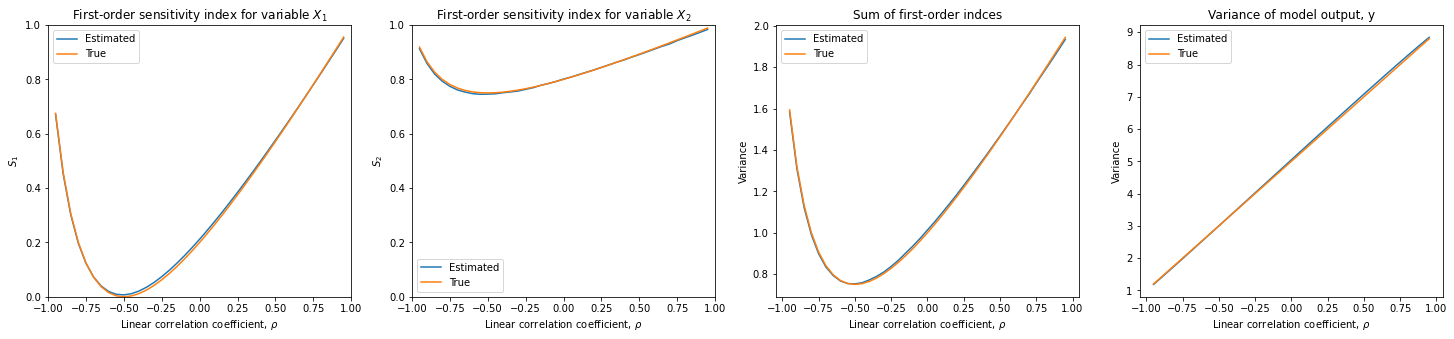

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))

ax1.plot(rho_c3a, SSc3a[:,0])
ax1.plot(rho_c3a, SSc3a_true[:,0])
ax1.set_xlim([-1,1])
ax1.set_ylim([0,1])
ax1.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax1.set_ylabel(r'$S_1$')
ax1.legend(['Estimated', 'True'])
ax1.set_title(r'First-order sensitivity index for variable $X_1$');

ax2.plot(rho_c3a, SSc3a[:,1])
ax2.plot(rho_c3a, SSc3a_true[:,1])
ax2.set_xlim([-1,1])
ax2.set_ylim([0,1])
ax2.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax2.set_ylabel(r'$S_2$')
ax2.legend(['Estimated', 'True'])
ax2.set_title(r'First-order sensitivity index for variable $X_2$');

ax3.plot(rho_c3a, SSc3a[:,0] + SSc3a[:,1])
ax3.plot(rho_c3a, SSc3a_true[:,0] + SSc3a_true[:,1])
ax3.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax3.set_ylabel(r'Variance')
ax3.legend(['Estimated', 'True'])
ax3.set_title('Sum of first-order indces');

ax4.plot(rho_c3a, varYc3a)
ax4.plot(rho_c3a, varYc3a_true)
ax4.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax4.set_ylabel(r'Variance')
ax4.legend(['Estimated', 'True'])
ax4.set_title('Variance of model output, y');

**Observations:** (1) The $S_i$'s are functions of rho; and (2) The sum of the $S_i$'s is no longer 1 for an additive model.


## Example from Kucherenko et al.(2012), Sec. 3.3 and test case 3 (Ishigami function)

To showcase the approach, we will initially consider the following simple problem: 

$$ y = \sin(x_1) + 7 \sin^2(x_2) + 0.1 x_3^4 \sin(x_1) $$

where the variables are assumed to follow a uniform distribution, i.e. $x_i \sim \mathcal{U}(-\pi,\pi), i \in \{1,2,3\}$. Note that Kucherenko et al.(2012), Fig. 

In [28]:
def genCorrelatedSamples_3b(Zuncor, PearsonsCorr, lower, upper):
    m = Zuncor.shape[1]
    L = np.linalg.cholesky(PearsonsCorr) # cholesky decomposition of covariance (correlation) matrix
    Zcor = np.dot(L, Zuncor.T).T # correlated standard normal samples
    U = ss.norm.cdf(Zcor) # correlated uniformly distributed samples
    X = np.zeros(U.shape) 
    for i in range(m):
        X[:,i] = ss.uniform(loc=lower, scale=upper-lower).ppf(U[:,i]) # define transformation
    y = np.sin(X[:,0]) + 7 * np.sin(X[:,1])**2 + 0.1 * X[:,2]**4 * np.sin(X[:,0])
    return(X, y)

def randomSamplingWithBinning_c3b(lower, upper, rho, Nsamp, Nbins):
    # initialization
    mX = 3
    nRho = len(rho)
    subset = Nsamp / Nbins; 
    # allocate objects
    varY = np.zeros([nRho])
    VV = np.zeros([nRho, mX])
    SS = np.zeros([nRho, mX])
    # Sample independent realizations in Z space
    Zuncor = lhs_Zuncor_sampler_c3a(mX, Nsamp)
    # loop over rho vector
    for j in range(nRho):
        PearsonsCorr = np.zeros([3,3]); np.fill_diagonal(PearsonsCorr,1); PearsonsCorr[0,2] = PearsonsCorr[2,0] = rho[j] # define linear correlation matrix
        X, y = genCorrelatedSamples_3b(Zuncor, PearsonsCorr, lower, upper) # transform samples to dependent samples in X space
        # model output variance; object allocation and analytical solution
        varY[j] = np.var(y) 
        f0Y = np.mean(y)
        # loop over variables
        for i in range(mX):
            # sort arrays according to Xi
            ix = np.argsort(X[:,i])
            yi = y[ix]; # Xi = X[ix,i];
            # allocate object for mean output in bin k of Xi
            meanYik = np.zeros([Nbins])
            # loop over bins
            for k in range(Nbins):
                kind = np.arange(k*subset, (k+1)*subset, 1).astype(int);
                yik = yi[kind]; # Xik = Xi[kind]; 
                meanYik[k] = np.mean(yik);

#             VV[j,i] = np.var(meanYik)
            VV[j,i] = np.mean(meanYik**2) - f0Y**2
            SS[j,i] = VV[j,i] / varY[j]
            
    return(varY, VV, SS)

In [29]:
lower_c3b = -np.pi
upper_c3b = np.pi
rho_c3b = np.arange(-0.95, 1, 0.05); nRho_c3b = len(rho_c3b)
Nsamp_c3b = 5000 # number of samples (should be devidable by Nbins)
Nbins_c3b = 50; # define number of slices

np.random.seed(42)
varYc3b, VVc3b, SSc3b = randomSamplingWithBinning_c3b(lower_c3b, upper_c3b, rho_c3b, Nsamp_c3b, Nbins_c3b)

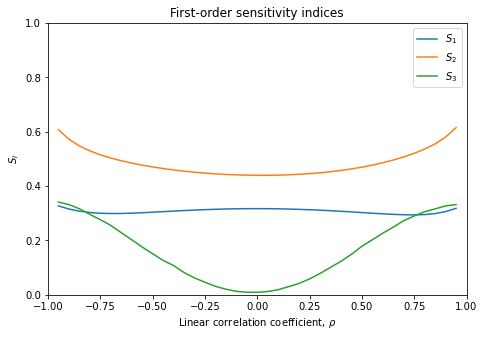

In [30]:
plt.figure(figsize=(7.5,5))

plt.plot(rho_c3b, SSc3b[:,0])
plt.plot(rho_c3b, SSc3b[:,1])
plt.plot(rho_c3b, SSc3b[:,2])
plt.xlim([-1,1])
plt.ylim([0,1])
plt.xlabel(r'Linear correlation coefficient, $\rho$')
plt.ylabel(r'$S_i$')
plt.legend([r'$S_1$', r'$S_2$', r'$S_3$'])
plt.title(r'First-order sensitivity indices');

Note that the plot compares well with Kucherenko et al.(2012), Figure 3.


# Sampling method of Kucherenko et al.(2012) - double-loop implementation

In Kucherenko et al.(2012), the definition of the first-order and total sensitivity indices for dependent inputs follow the definition of the Sobol indices for independent inputs, see e.g. Saltelli et al.(2008), but for dependent case, a conditional sampling scheme is used, as the distribution of the remaining variables is altered when one variable is fixed to a certain value.

***
Kucherenko, S., Tarantola, S., & Annoni, P. (2012). Estimation of global sensitivity indices for models with dependent variables. Computer physics communications, 183(4), 937-946.

Saltelli, A., Ratto, M., Andres, T., Campolongo, F., Cariboni, J., Gatelli, D., Saisana, M., and Tarantola, S. (2008). Global sensitivity analysis: the primer. John Wiley & Sons.
***

## Implementation

### First-order sensitivity index

In the following the steps needed for the implementation of the fist-order index is sketched for the case of a Gaussian copula:

for each variable $X_i$;

1. Generate $N_{out}$ samples of $U_i \sim \mathcal{U}(0,1)$ leading to the vector $\mathbf{u}_i$ 

2. Transform $\mathbf{u}_i$ to standard normal variates, i.e. $\mathbf{z}_i = \Phi^1(\mathbf{u}_i)$

3. Sample the remaining inputs conditional on $\mathbf{z}_i$ $N_{inn}$ times using the standard rules for conditioning Gaussians, i.e. 
$$\mathbf{Z}_{\sim i} \sim \mathcal{N}(   \boldsymbol\mu_{\sim i} + \Sigma_{\sim i, i} \Sigma_{i, i}^{-1} (Z_i - \mu_i),   \Sigma_{\sim i, \sim i} -  \Sigma_{\sim i, i} \Sigma_{i, i}^{-1} \Sigma_{i, \sim i}  ) $$
which simplifies to the following expression:
$$\mathbf{Z}_{\sim i} \sim \mathcal{N}(  \Sigma_{\sim i, i} Z_i,   \Sigma_{\sim i, \sim i} -  \Sigma_{\sim i, i} \Sigma_{i, \sim i}  ) $$
as we are operating in standard normal space, i.e. with mean zero and variance one. Also observe that only the mean depends on the actual value of the conditioning variable, thus
$$ \mathbf{z}_{\sim i} = \Sigma_{\sim i, i} z_i + \mathbf{z}_{\sim i}^0 $$
where $\mathbf{Z}_{\sim i}^0 \sim \mathcal{N}( \mathbf{0}, \Sigma_{\sim i, \sim i} -  \Sigma_{\sim i, i} \Sigma_{i, \sim i})$. That is the samples $\mathbf{z}_{\sim i}^0$ can be reused for each realization of the conditioning variable $z_{i}$.

4. Combining the samples of $Z_i$ and $\mathbf{Z}_{\sim i}$ gives the sample matrix $\hat{\mathbf{Z}}_{\cdot|i}$

5. Marginal back-transformation of the standard normal variates into original variates
$$ \mathbf{x}_{j|i} = F^{-1}_{X_j}(\Phi(\mathbf{z}_{j|i})) $$

6. Calculate $\mathbb{V}_i$ as
$$ \mathbb{V}_i = \mathbb{V}_{X_i}[ \mathbb{E}_{\mathbf{X}_{\sim i} }[Y|X_i] ]$$

### Total-order sensitivity index

In the following the steps needed for the implementation of the total-order index is sketched for the case of a Gaussian copula:

for each variable $X_i$;

1. Generate $N_{out}$ samples in standard normal space of the remaining variables with correlation matrix $\Sigma_{\sim i, \sim i}$

2. For each realization of the variables $\mathbf{Z}_{\sim i}$, variable $Z_i$ is sampled $N_{inn}$ times as
$${Z}_{i} \sim \mathcal{N}(   \mu_{i} + \Sigma_{\sim i, i} \Sigma_{\sim i, \sim i}^{-1} (\mathbf{Z}_{\sim i} - \boldsymbol\mu_{\sim i}),   \Sigma_{i,i} -  \Sigma_{\sim i, i} \Sigma_{\sim i, \sim i}^{-1} \Sigma_{i, \sim i}  ) $$
which simplifies to the following expression:
$${Z}_{i} \sim \mathcal{N}(   \Sigma_{\sim i, i} \Sigma_{\sim i, \sim i}^{-1} \mathbf{Z}_{\sim i},   1 -  \Sigma_{\sim i, i} \Sigma_{\sim i, \sim i}^{-1} \Sigma_{i, \sim i}  ) $$
as we are operating in standard normal space, i.e. with mean zero and variance one. Again, we observe that only the mean depends on the actual value of the conditioning variable, thus
$$ {z}_{i} = \Sigma_{\sim i, i} \Sigma_{\sim i, \sim i}^{-1} \mathbf{z}_{\sim i} + \mathbf{z}_{i}^0 $$
where ${Z}_{i}^0 \sim \mathcal{N}(0, 1 -  \Sigma_{\sim i, i} \Sigma_{\sim i, \sim i}^{-1} \Sigma_{i, \sim i} )$. That is, the samples ${z}_{i}^0$ can be reused for each realization of the conditioning variable $\mathbf{z}_{\sim i}$.

4. Combining the samples of $Z_i$ and $\mathbf{Z}_{\sim i}$ gives the sample matrix $\hat{\mathbf{Z}}_{\cdot|\sim i}$

5. Marginal back-transformation of the standard normal variates into original variates
$$ \mathbf{x}_{j|\sim i} = F^{-1}_{X_j}(\Phi(\mathbf{z}_{j|\sim i})) $$

6. Calculate $\mathbb{V}^T_i$ as
$$ \mathbb{V}^T_i = \mathbb{E}_{\mathbf{X}_{\sim i}}[ \mathbb{V}_{X_i}[Y|\mathbf{X}_{\sim i}] ]$$

In [53]:
# sample uncorrelated, standard normal variates
def lhs_Zuncor_sampler_c4a(mX, Nsamp):
    lhs_sampler = smt.sampling_methods.LHS(xlimits=np.tile(np.array([0,1]), (mX, 1))) # latin hypercube sampling
    Ulhs = lhs_sampler(Nsamp) # do.
    Zuncor = ss.norm.ppf(Ulhs) # uncorrelated standard normal samples
    return(Zuncor)

def z2x_and_y_4a(Zcor):
    meanX = np.zeros([2])
    stdX = np.array([1,2])
    Xcor = Zcor * stdX + meanX
    ycor = Xcor[:,0] + Xcor[:,1];
    return(Xcor, ycor)

def firstKUCHdoubleLoop_c4a(Zuncor, PearsonsCorr, nIn, f0Y, func_z2x_and_y):
    nOut, mOut = Zuncor.shape
    VV = np.zeros([mOut])
    for i in range(mOut):
        Zuncor_i = Zuncor[:,i] # samples form outer loop
        Zuncor_not_i = lhs_Zuncor_sampler_c4a(mOut-1, nIn) # samples for inner loop
        # Decompose covariance matrix
        PearsonsCorr_not_i_not_i = np.delete(PearsonsCorr, i, axis=0); PearsonsCorr_not_i_not_i = np.delete(PearsonsCorr_not_i_not_i, i, axis=1)
        PearsonsCorr_not_i_i = np.delete(PearsonsCorr, i, axis=0); PearsonsCorr_not_i_i = PearsonsCorr_not_i_i[:,i].reshape(-1,1)
        # conditional covariance and its cholesky decomposition
        Sig_not_i = PearsonsCorr_not_i_not_i - PearsonsCorr_not_i_i.dot(PearsonsCorr_not_i_i.T)
        L_not_i = np.linalg.cholesky(Sig_not_i) # cholesky decomposition of covariance (correlation) matrix
        # zero-mean, conditional samples
        Zcor_not_i_0 = np.dot(L_not_i, Zuncor_not_i.T).T # correlated standard normal samples
        
        var_indices = np.arange(0, mOut, 1)
        var_indices_not_i = np.delete(var_indices, i, axis=0)
        meanYij = np.zeros([nOut])
        for j in range(nOut):
            Zuncor_i_j = Zuncor_i[j]; # one realization of Zi
            # conditional mean
            mu_not_i_j = PearsonsCorr_not_i_i.T * Zuncor_i_j
            # conditional samples
            Zcor_not_i_j = mu_not_i_j + Zcor_not_i_0
            # Design matrix i,j
            ZZ_cor_i_j = np.zeros([nIn,mOut])
            ZZ_cor_i_j[:,i] = np.repeat(Zuncor_i_j, [nIn]); 
            ZZ_cor_i_j[:,var_indices_not_i] = Zcor_not_i_j;
            # Inputs and outputs in the original space, X
            X_cor_i_j, y_cor_i_j = func_z2x_and_y(ZZ_cor_i_j)
            # mean effect conditional on x[i,j]
            meanYij[j] = np.mean(y_cor_i_j);
       
        # Updata unnormalized variance vector
        VV[i] = np.mean(meanYij**2) - f0Y**2
    
    return(VV)

def totalKUCHdoubleLoop_c4a(Zuncor, PearsonsCorr, nIn, func_z2x_and_y):
    nOut, mOut = Zuncor.shape
    VVT = np.zeros([mOut])
    for i in range(mOut):
        var_indices = np.arange(0, mOut, 1)
        var_indices_not_i = np.delete(var_indices, i, axis=0)
        Zuncor_not_i = Zuncor[:,var_indices_not_i]
        Zuncor_i_0 = lhs_Zuncor_sampler_c4a(1, nIn) # samples for inner loop
        # Decompose covariance matrix
        PearsonsCorr_not_i_not_i = np.delete(PearsonsCorr, i, axis=0); PearsonsCorr_not_i_not_i = np.delete(PearsonsCorr_not_i_not_i, i, axis=1)
        PearsonsCorr_not_i_i = np.delete(PearsonsCorr, i, axis=0); PearsonsCorr_not_i_i = PearsonsCorr_not_i_i[:,i].reshape(-1,1)
        # conditional covariance and its cholesky decomposition
        Sig_not_i = PearsonsCorr_not_i_not_i - PearsonsCorr_not_i_i.dot(PearsonsCorr_not_i_i.T)
        L_not_i = np.linalg.cholesky(Sig_not_i) # cholesky decomposition of covariance (correlation) matrix
        # zero-mean, conditional samples
        Zcor_not_i = np.dot(L_not_i, Zuncor_not_i.T).T # correlated standard normal samples
        
        varYij = np.zeros([nOut])
        for j in range(nOut):
            Zcor_not_i_j = Zcor_not_i[j,:]; # one realization of Z_not_i
            # conditional mean
            invPearsonsCorr_not_i_not_i = np.linalg.inv(PearsonsCorr_not_i_not_i)
            mu_i_j = PearsonsCorr_not_i_i.T.dot(invPearsonsCorr_not_i_not_i).dot(Zcor_not_i_j);
            # conditional samples
            Zcor_i_j = mu_i_j + Zuncor_i_0 * np.sqrt( 1 - PearsonsCorr_not_i_i.T.dot(invPearsonsCorr_not_i_not_i).dot(PearsonsCorr_not_i_i) );
            # Design matrix i,j
            ZZ_cor_i_j = np.zeros([nIn,mOut])
            ZZ_cor_i_j[:,i] = Zcor_i_j.reshape(-1)
            ZZ_cor_i_j[:,var_indices_not_i] = np.array([Zcor_not_i_j,]*nIn);
            # Inputs and outputs in the original space, X
            X_cor_i_j, y_cor_i_j = func_z2x_and_y(ZZ_cor_i_j)
            # variance conditional on x[not i, j]
            varYij[j] = np.var(y_cor_i_j) # variance of the outputs
       
        # Updata variance vector
        VVT[i] = np.mean(varYij) # mean of variances
    
    return(VVT)

def KUCHdoubleLoop_incl_rho_and_norm_c4a(nOut, nIn, rho):
    mX = 2
    nRho = len(rho)
    varY = np.zeros([nRho])
    VV = np.zeros([nRho, mX])
    SS = np.zeros([nRho, mX])
    VVT = np.zeros([nRho, mX])
    SST = np.zeros([nRho, mX])
    for j in range(nRho):
        Zuncor_j = lhs_Zuncor_sampler_c4a(mX, nOut)
        PearsonsCorr_j = np.ones([2,2]); PearsonsCorr_j[0,1] = PearsonsCorr_j[1,0] = rho[j] # define linear correlation matrix
        # unconditional quantities
        L_j = np.linalg.cholesky(PearsonsCorr_j) # cholesky decomposition of covariance (correlation) matrix
        Zcor_j = np.dot(L_j, Zuncor_j.T).T # correlated standard normal samples
        Xcor_j, y_cor_j = z2x_and_y_4a(Zcor_j)
        f0y_j = np.mean(y_cor_j)
        varY_j = np.mean(y_cor_j**2) - f0y_j**2
        # conditional quantities
        VV_j = firstKUCHdoubleLoop_c4a(Zuncor_j, PearsonsCorr_j, nIn, f0y_j, z2x_and_y_4a)
        VVT_j = totalKUCHdoubleLoop_c4a(Zuncor_j, PearsonsCorr_j, nIn, z2x_and_y_4a)
        # collect results
        VV[j,:] = VV_j
        SS[j,:] = VV[j,:]/varY_j
        VVT[j,:] = VVT_j;
        SST[j,:] = VVT[j,:]/varY_j;
        varY[j] = varY_j
    
    return(varY, VV, SS, VVT, SST)

In [54]:
rho_c4a = np.arange(-0.95, 1, 0.05); nRho_c4a = len(rho_c4a)
nOut_c4a = 2500; 
nIn_c4a = 1000; 

np.random.seed(42)
varYc4a, VVc4a, SSc4a, VVTc4a, SSTc4a = KUCHdoubleLoop_incl_rho_and_norm_c4a(nOut_c4a, nIn_c4a, rho_c4a)

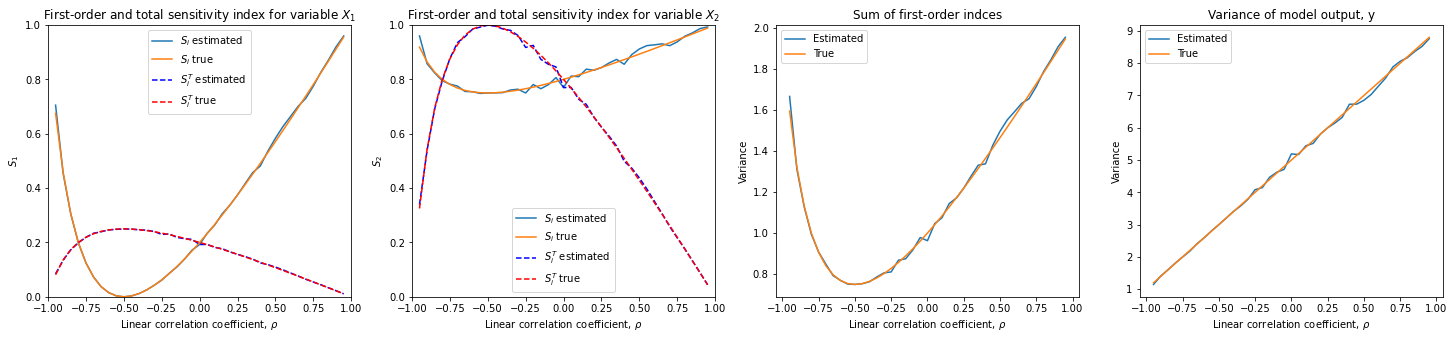

In [55]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))

ax1.plot(rho_c4a, SSc4a[:,0])
ax1.plot(rho_c3a, SSc3a_true[:,0])
ax1.plot(rho_c4a, SSTc4a[:,0], 'b--')
ax1.plot(rho_c3a, 1-SSc3a_true[:,1], 'r--')
ax1.set_xlim([-1,1])
ax1.set_ylim([0,1])
ax1.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax1.set_ylabel(r'$S_1$')
ax1.legend([r'$S_i$ estimated', r'$S_i$ true', r'$S_i^T$ estimated', r'$S_i^T$ true'])
ax1.set_title(r'First-order and total sensitivity index for variable $X_1$');

ax2.plot(rho_c4a, SSc4a[:,1])
ax2.plot(rho_c3a, SSc3a_true[:,1])
ax2.plot(rho_c4a, SSTc4a[:,1], 'b--')
ax2.plot(rho_c3a, 1-SSc3a_true[:,0], 'r--')
ax2.set_xlim([-1,1])
ax2.set_ylim([0,1])
ax2.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax2.set_ylabel(r'$S_2$')
ax2.legend([r'$S_i$ estimated', r'$S_i$ true', r'$S_i^T$ estimated', r'$S_i^T$ true'])
ax2.set_title(r'First-order and total sensitivity index for variable $X_2$');

ax3.plot(rho_c4a, SSc4a[:,0] + SSc4a[:,1])
ax3.plot(rho_c3a, SSc3a_true[:,0] + SSc3a_true[:,1])
ax3.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax3.set_ylabel(r'Variance')
ax3.legend(['Estimated', 'True'])
ax3.set_title('Sum of first-order indces');

ax4.plot(rho_c4a, varYc4a)
ax4.plot(rho_c3a, varYc3a_true)
ax4.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax4.set_ylabel(r'Variance')
ax4.legend(['Estimated', 'True'])
ax4.set_title('Variance of model output, y');

**Observations:** (1) $S_i$ and $S_i^T$ are functions of rho; (2) $S_i^T$ is not always larger than $S_i$; and (3) The sum of the $S_i$'s is no longer 1 for an additive model.

In [56]:
def z2x_and_y_4b(Zcor):
    m = Zcor.shape[1]
    lower, upper = -np.pi, np.pi
    U = ss.norm.cdf(Zcor) # correlated uniformly distributed samples
    X = np.zeros(U.shape) 
    for i in range(m):
        X[:,i] = ss.uniform(loc=lower, scale=upper-lower).ppf(U[:,i]) # define transformation
    y = np.sin(X[:,0]) + 7 * np.sin(X[:,1])**2 + 0.1 * X[:,2]**4 * np.sin(X[:,0])
    return(X, y)

def KUCHdoubleLoop_incl_rho_and_norm_c4b(nOut, nIn, rho):
    mX = 3
    nRho = len(rho)
    varY = np.zeros([nRho])
    VV = np.zeros([nRho, mX])
    SS = np.zeros([nRho, mX])
    VVT = np.zeros([nRho, mX])
    SST = np.zeros([nRho, mX])
    for j in range(nRho):
#         print('iteration', j, 'of', nRho-1)
        Zuncor_j = lhs_Zuncor_sampler_c4a(mX, nOut)
        PearsonsCorr_j = np.zeros([3,3]); np.fill_diagonal(PearsonsCorr_j,1); PearsonsCorr_j[0,2] = PearsonsCorr_j[2,0] = rho[j] # define linear correlation matrix
        # unconditional quantities
        L_j = np.linalg.cholesky(PearsonsCorr_j) # cholesky decomposition of covariance (correlation) matrix
        Zcor_j = np.dot(L_j, Zuncor_j.T).T # correlated standard normal samples
        Xcor_j, y_cor_j = z2x_and_y_4b(Zcor_j)
        f0y_j = np.mean(y_cor_j)
        varY_j = np.mean(y_cor_j**2) - f0y_j**2
        # conditional quantities
        VV_j = firstKUCHdoubleLoop_c4a(Zuncor_j, PearsonsCorr_j, nIn, f0y_j, z2x_and_y_4b)
        VVT_j = totalKUCHdoubleLoop_c4a(Zuncor_j, PearsonsCorr_j, nIn, z2x_and_y_4b)
        # collect results
        VV[j,:] = VV_j
        SS[j,:] = VV[j,:]/varY_j
        VVT[j,:] = VVT_j;
        SST[j,:] = VVT[j,:]/varY_j;
        varY[j] = varY_j
    
    return(varY, VV, SS, VVT, SST)

In [94]:
rho_c4b = np.arange(-0.95, 1, 0.05); nRho_c4a = len(rho_c4a)
nOut_c4b = 500; 
nIn_c4b = 500; 

# np.random.seed(42)
# varYc4b, VVc4b, SSc4b, VVTc4b, SSTc4b = KUCHdoubleLoop_incl_rho_and_norm_c4b(nOut_c4b, nIn_c4b, rho_c4b)

# # save results
# with open('SA_varianceBased_correlatedInputs_SAindicesEtc_c4b.pkl', 'wb') as f:
#     pickle.dump((varYc4b, VVc4b, SSc4b, VVTc4b, SSTc4b), f)

# load results
varYc4b, VVc4b, SSc4b, VVTc4b, SSTc4b = pickle.load(open('SA_varianceBased_correlatedInputs_SAindicesEtc_c4b.pkl', 'rb'))

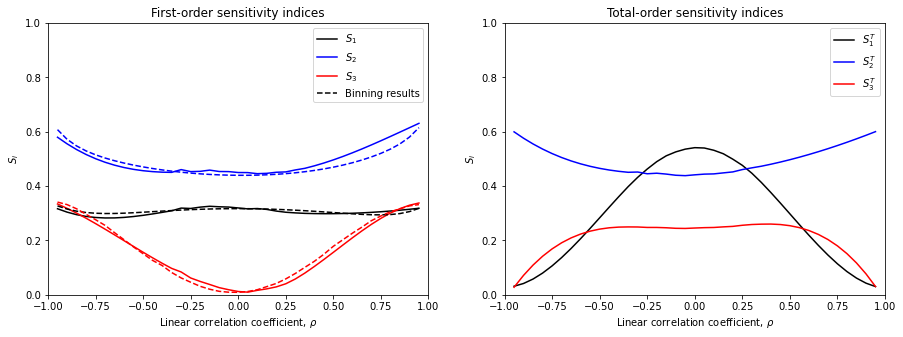

In [95]:
import scipy.signal

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(rho_c4b, scipy.signal.savgol_filter(SSc4b[:,0], 25, 3), 'k-') # apply smooting
ax1.plot(rho_c4b, scipy.signal.savgol_filter(SSc4b[:,1], 25, 3), 'b-')
ax1.plot(rho_c4b, scipy.signal.savgol_filter(SSc4b[:,2], 25, 3), 'r-')
ax1.plot(rho_c3b, SSc3b[:,0], 'k--')
ax1.plot(rho_c3b, SSc3b[:,1], 'b--')
ax1.plot(rho_c3b, SSc3b[:,2], 'r--')
ax1.set_xlim([-1,1])
ax1.set_ylim([0,1])
ax1.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax1.set_ylabel(r'$S_i$')
ax1.legend([r'$S_1$', r'$S_2$', r'$S_3$', r'Binning results'])
ax1.set_title(r'First-order sensitivity indices');

ax2.plot(rho_c4b, scipy.signal.savgol_filter(SSTc4b[:,0], 25, 3), 'k-') # apply smooting
ax2.plot(rho_c4b, scipy.signal.savgol_filter(SSTc4b[:,1], 25, 3), 'b-')
ax2.plot(rho_c4b, scipy.signal.savgol_filter(SSTc4b[:,2], 25, 3), 'r-')
ax2.set_xlim([-1,1])
ax2.set_ylim([0,1])
ax2.set_xlabel(r'Linear correlation coefficient, $\rho$')
ax2.set_ylabel(r'$S_i$')
ax2.legend([r'$S_1^T$', r'$S_2^T$', r'$S_3^T$', r'Binning results'])
ax2.set_title(r'Total-order sensitivity indices');

Note that the plot compares well with Kucherenko et al.(2012), Figure 3.